In [2]:
import sys,os
import numpy as np
import matplotlib.pyplot as plt
from pkg_resources import resource_filename
from desiutil.log import get_logger
from desitarget import cuts
#import astropy.io.fits as pyfits
import fitsio
import healpy as hp


In [3]:
def mag2flux(mag) :
    return 10**(-0.4*(mag-22.5))


In [4]:
def flux2mag(flux) :
    mag = -2.5*np.log10(flux*(flux>0)+0.001*(flux<=0)) + 22.5
    mag[(flux<=0)] = 0.
    return mag


In [5]:
def prof(x,y,bins) :
    '''
    what AJR calls the '1d plots'; e.g., normalized density versus x
    '''
    h0,bins=np.histogram(x,bins=bins)
    hx,bins=np.histogram(x,bins=bins,weights=x)
    hy,bins=np.histogram(x,bins=bins,weights=y)
    hy2,bins=np.histogram(x,bins=bins,weights=y**2)
    ii=h0>2
    mx=hx[ii]/h0[ii]
    my=hy[ii]/h0[ii]
    var=hy2[ii]/h0[ii]-my**2
    ey=np.sqrt(var*(var>0))/np.sqrt(h0[ii])
    return mx,my,ey


In [6]:
def colorplot(ra,dec,z,vmin=None,vmax=None) :
    nbins=300
    raoffset=80.
    rap=(ra+raoffset)%360
    h0,xbins,ybins = np.histogram2d(rap,dec,bins=nbins)
    hz,xbins,ybins = np.histogram2d(rap,dec,bins=nbins,weights=z*(z>=0))
    mz=hz/(h0+(h0==0))*(h0>0)
    plt.imshow(mz.T,origin=0,extent=(xbins[0]-raoffset,xbins[-1]-raoffset,ybins[0],ybins[-1]),aspect="auto",vmin=vmin,vmax=vmax)
    plt.colorbar()


In [7]:
target="ELG"
if target == 'LRG':
    colorcuts_function = cuts.isLRG_colors
elif target == 'ELG':
    colorcuts_function = cuts.isELG_colors
elif target == 'QSO':
    colorcuts_function = cuts.isQSO_colors
else:
    colorcuts_function = None


In [36]:
#truthf = '/global/cscratch1/sd/raichoor/tmpdir/tmp.dr7.41ra44.-1dec0.clean.deep.fits' #original
truthf = '/global/cscratch1/sd/raichoor/desi_mcsyst/desi_mcsyst_truth.dr7.34ra38.-7dec-3.fits' #new HSC

In [37]:
truth  = fitsio.read(truthf,1)
print(truth.dtype.names)

('brickname', 'objid', 'type', 'ra', 'dec', 'g', 'r', 'z', 'w1', 'w2', 'galdepth_g', 'galdepth_r', 'galdepth_z', 'hsc_object_id', 'hsc_ra', 'hsc_dec', 'hsc_mizuki_photoz_best')


In [38]:
print(len(truth))
gmag  = truth["g"]
w = gmag < 24.5
truth = truth[w]
print(len(truth))
gmag  = truth["g"]
rmag  = truth["r"]
zmag  = truth["z"]


549181
156861


/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()


In [39]:
gflux = mag2flux(truth["g"])
rflux = mag2flux(truth["r"])
zflux = mag2flux(truth["z"])
w1flux = np.zeros(gflux.shape)
w2flux = np.zeros(gflux.shape)

In [40]:
true_selection = colorcuts_function(gflux=gflux, rflux=rflux, zflux=zflux, w1flux=w1flux, w2flux=w2flux, south=True)
star_selection = ((gmag-rmag)>(1.5*(rmag-zmag)+0.0))&((gmag-rmag)<(1.5*(rmag-zmag)+0.4))&((gmag-rmag)>(-1.5*(rmag-zmag)+0.3))&((gmag-rmag)<(-1.5*(rmag-zmag)+2.0))
true_mean=np.mean(true_selection.astype(float))


/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/desitarget/master/py/desitarget/cuts.py:315: RuntimeWarning: invalid value encountered in greater
  elg &= r - z > 0.3                  # blue cut.
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/desitarget/master/py/desitarget/cuts.py:316: RuntimeWarning: invalid value encountered in less
  elg &= r - z < 1.6                  # red cut.
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/desitarget/master/py/desitarget/cuts.py:317: RuntimeWarning: invalid value encountered in less
  elg &= g - r < -1.2*(r - z) + 1.6   # OII flux cut.
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/desitarget/master/py/desitarget/cuts.py:323: RuntimeWarning: invalid value encountered in less
  elg &= g - r < 1.15*(r - z) - 0.15
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid valu

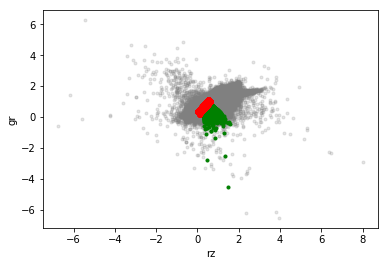

In [41]:
#plt.figure("model")
#plt.subplot(1,2,1)
plt.plot(rmag-zmag,gmag-rmag,".",alpha=0.2,color="gray")
plt.plot((rmag-zmag)[true_selection],(gmag-rmag)[true_selection],".",alpha=1,color="green")
plt.plot((rmag-zmag)[star_selection],(gmag-rmag)[star_selection],".",alpha=1,color="red")
plt.xlabel("rz")
plt.ylabel("gr")
plt.show()

13.8057 24.5 156861


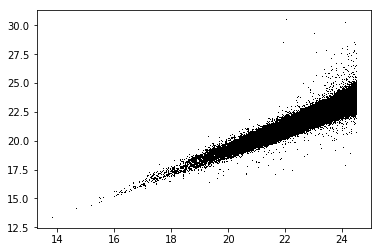

(array([    1,    14,    67,   219,   916,  2808,  7524, 18527, 58615, 68169]), array([ 14. ,  15.1,  16.2,  17.3,  18.4,  19.5,  20.6,  21.7,  22.8,
        23.9,  25. ]))


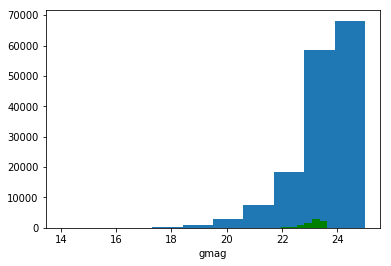

In [42]:
#plt.subplot(1,2,2)
print(min(gmag),max(gmag),len(gmag))
plt.plot(gmag,rmag,'k,')
plt.show()
h = np.histogram(gmag,range=(14,25))
print(h)
plt.hist(gmag,range=(14,25))
plt.hist(gmag[true_selection],bins=40,color="green",range=(14,25))
plt.xlabel("gmag")

plt.show()

In [43]:
seed = 1
rand = np.random.RandomState(seed)

In [16]:
#read in DR8 properties map
pixfn      = '/project/projectdirs/desi/target/catalogs/dr8/0.31.1/pixweight/pixweight-dr8-0.31.1.fits'
pix,header=fitsio.read(pixfn,header=True)
HPXNSIDE=header["HPXNSIDE"]
print(pix.dtype.names)
print("number of pixels=",pix.size)
ii=np.where((pix["GALDEPTH_G"]>0)&(pix["GALDEPTH_R"]>0)&(pix["GALDEPTH_Z"]>0)&(pix["FRACAREA"]>0.01))[0]
npix=ii.size
print(npix)


('HPXPIXEL', 'FRACAREA', 'STARDENS', 'EBV', 'PSFDEPTH_G', 'PSFDEPTH_R', 'PSFDEPTH_Z', 'GALDEPTH_G', 'GALDEPTH_R', 'GALDEPTH_Z', 'PSFDEPTH_W1', 'PSFDEPTH_W2', 'PSFSIZE_G', 'PSFSIZE_R', 'PSFSIZE_Z', 'ELG', 'LRG', 'QSO', 'BGS_ANY', 'MWS_ANY', 'ALL', 'STD_FAINT', 'STD_BRIGHT', 'LRG_1PASS', 'LRG_2PASS', 'BGS_FAINT', 'BGS_BRIGHT', 'BGS_WISE', 'MWS_BROAD', 'MWS_MAIN_RED', 'MWS_MAIN_BLUE', 'MWS_WD', 'MWS_NEARBY')
number of pixels= 786432
374065


In [17]:
pix = pix[ii]
print(len(pix))
depth_keyword="PSFDEPTH"
gdepth=-2.5*np.log10(5/np.sqrt(pix[depth_keyword+"_G"]))+22.5
rdepth=-2.5*np.log10(5/np.sqrt(pix[depth_keyword+"_R"]))+22.5
zdepth=-2.5*np.log10(5/np.sqrt(pix[depth_keyword+"_Z"]))+22.5


374065


In [18]:
efficiency=np.zeros(npix)
efficiency_of_true_elgs=np.zeros(npix)
efficiency_of_stars=np.zeros(npix)
R_G=3.63476336 # for R_V=3.1 , ext_odonnell , at effective wavelength
R_R=2.55808601
R_Z=1.43322196


In [19]:
gsigma=1./np.sqrt(pix[depth_keyword+"_G"])
rsigma=1./np.sqrt(pix[depth_keyword+"_R"])
zsigma=1./np.sqrt(pix[depth_keyword+"_Z"])


In [46]:
# keep same random number
grand = np.random.normal(size=gflux.shape)
rrand = np.random.normal(size=rflux.shape)
zrand = np.random.normal(size=zflux.shape)

In [44]:
print(len(gsigma),len(pix))

374065 374065


In [68]:
def ELGeffcalc(gsig,rsig,zsig,south=True):
    '''
    calculate the ELG efficiency for given g,r,z flux uncertainties and a given region's selection
    '''
    mgflux = gflux + grand*gsig
    mrflux = rflux + rrand*rsig
    mzflux = zflux + zrand*zsig
    
    combined_snr = np.sqrt(mgflux**2/gsig**2+mrflux**2/rsig**2+mzflux**2/zsig**2) #combined signal to noise; tractor ignores anything < 6
    
    selection = colorcuts_function(gflux=mgflux, rflux=mrflux, zflux=mzflux, w1flux=w1flux, w2flux=w2flux, south=south) * ( combined_snr > 6 ) * ( gflux > 4*gsig ) * ( rflux > 3.5*rsig ) * ( zflux > 2.*zsig )
        
    efficiency=np.mean(selection.astype(float))/true_mean
    efficiency_of_true_elgs=np.mean((true_selection*selection).astype(float))/true_mean
    efficiency_of_stars=np.mean((star_selection*selection).astype(float))/true_mean  
    
    return efficiency,efficiency_of_true_elgs,efficiency_of_stars
    

In [69]:
for j in range(0,len(pix)):# loop on sky pixels using funciton

    if j%5000==0 : print("{}/{}, {:3.2f}%".format(j,ii.size,float(j)/ii.size*100.))
    
    gsig = gsigma[j]*10**(0.4*R_G*pix["EBV"][j])
    rsig = rsigma[j]*10**(0.4*R_R*pix["EBV"][j])
    zsig = zsigma[j]*10**(0.4*R_Z*pix["EBV"][j])
    
    eff,efft,effs = ELGeffcalc(gsig,rsig,zsig,south=True)
    
    efficiency[j]=eff
    efficiency_of_true_elgs[j]=efft
    efficiency_of_stars[j]=effs

0/374065, 0.00%


/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/desitarget/master/py/desitarget/cuts.py:315: RuntimeWarning: invalid value encountered in greater
  elg &= r - z > 0.3                  # blue cut.
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/desitarget/master/py/desitarget/cuts.py:316: RuntimeWarning: invalid value encountered in less
  elg &= r - z < 1.6                  # red cut.
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/desitarget/master/py/desitarget/cuts.py:317: RuntimeWarning: invalid value encountered in less
  elg &= g - r < -1.2*(r - z) + 1.6   # OII flux cut.
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/desitarget/master/py/desitarget/cuts.py:323: RuntimeWarning: invalid value encountered in less
  elg &= g - r < 1.15*(r - z) - 0.15
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid val

5000/374065, 1.34%
10000/374065, 2.67%
15000/374065, 4.01%
20000/374065, 5.35%
25000/374065, 6.68%
30000/374065, 8.02%
35000/374065, 9.36%
40000/374065, 10.69%
45000/374065, 12.03%
50000/374065, 13.37%
55000/374065, 14.70%
60000/374065, 16.04%
65000/374065, 17.38%
70000/374065, 18.71%
75000/374065, 20.05%
80000/374065, 21.39%
85000/374065, 22.72%
90000/374065, 24.06%
95000/374065, 25.40%
100000/374065, 26.73%
105000/374065, 28.07%
110000/374065, 29.41%
115000/374065, 30.74%
120000/374065, 32.08%
125000/374065, 33.42%
130000/374065, 34.75%
135000/374065, 36.09%
140000/374065, 37.43%
145000/374065, 38.76%
150000/374065, 40.10%
155000/374065, 41.44%
160000/374065, 42.77%
165000/374065, 44.11%
170000/374065, 45.45%
175000/374065, 46.78%
180000/374065, 48.12%
185000/374065, 49.46%
190000/374065, 50.79%
195000/374065, 52.13%
200000/374065, 53.47%
205000/374065, 54.80%
210000/374065, 56.14%
215000/374065, 57.48%
220000/374065, 58.81%
225000/374065, 60.15%
230000/374065, 61.49%
235000/374065, 

In [47]:
for j in range(0,len(pix)):# loop on sky pixels

    if j%5000==0 : print("{}/{}, {:3.2f}%".format(j,ii.size,float(j)/ii.size*100.))
    
    gsig = gsigma[j]*10**(0.4*R_G*pix["EBV"][j])
    rsig = rsigma[j]*10**(0.4*R_R*pix["EBV"][j])
    zsig = zsigma[j]*10**(0.4*R_Z*pix["EBV"][j])
    
    mgflux = gflux + grand*gsig
    mrflux = rflux + rrand*rsig
    mzflux = zflux + zrand*zsig
    
    combined_snr = np.sqrt(mgflux**2/gsig**2+mrflux**2/rsig**2+mzflux**2/zsig**2)

    selection = colorcuts_function(gflux=mgflux, rflux=mrflux, zflux=mzflux, w1flux=w1flux, w2flux=w2flux, south=True) * ( combined_snr > 6 ) * ( gflux > 4*gsig ) * ( rflux > 3.5*rsig ) * ( zflux > 2.*zsig )
        
    efficiency[j]=np.mean(selection.astype(float))/true_mean
    efficiency_of_true_elgs[j]=np.mean((true_selection*selection).astype(float))/true_mean
    efficiency_of_stars[j]=np.mean((star_selection*selection).astype(float))/true_mean

0/374065, 0.00%


/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/desitarget/master/py/desitarget/cuts.py:315: RuntimeWarning: invalid value encountered in greater
  elg &= r - z > 0.3                  # blue cut.
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/desitarget/master/py/desitarget/cuts.py:316: RuntimeWarning: invalid value encountered in less
  elg &= r - z < 1.6                  # red cut.
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/desitarget/master/py/desitarget/cuts.py:317: RuntimeWarning: invalid value encountered in less
  elg &= g - r < -1.2*(r - z) + 1.6   # OII flux cut.
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/desitarget/master/py/desitarget/cuts.py:323: RuntimeWarning: invalid value encountered in less
  elg &= g - r < 1.15*(r - z) - 0.15
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid val

5000/374065, 1.34%
10000/374065, 2.67%
15000/374065, 4.01%
20000/374065, 5.35%
25000/374065, 6.68%
30000/374065, 8.02%
35000/374065, 9.36%
40000/374065, 10.69%
45000/374065, 12.03%
50000/374065, 13.37%
55000/374065, 14.70%
60000/374065, 16.04%
65000/374065, 17.38%
70000/374065, 18.71%
75000/374065, 20.05%
80000/374065, 21.39%
85000/374065, 22.72%
90000/374065, 24.06%
95000/374065, 25.40%
100000/374065, 26.73%
105000/374065, 28.07%
110000/374065, 29.41%
115000/374065, 30.74%
120000/374065, 32.08%
125000/374065, 33.42%
130000/374065, 34.75%
135000/374065, 36.09%
140000/374065, 37.43%
145000/374065, 38.76%
150000/374065, 40.10%
155000/374065, 41.44%
160000/374065, 42.77%
165000/374065, 44.11%
170000/374065, 45.45%
175000/374065, 46.78%
180000/374065, 48.12%
185000/374065, 49.46%
190000/374065, 50.79%
195000/374065, 52.13%
200000/374065, 53.47%
205000/374065, 54.80%
210000/374065, 56.14%
215000/374065, 57.48%
220000/374065, 58.81%
225000/374065, 60.15%
230000/374065, 61.49%
235000/374065, 

In [48]:
print(min(efficiency),max(efficiency),np.mean(efficiency))

0.0317557626287 1.21750858264 1.03709633692


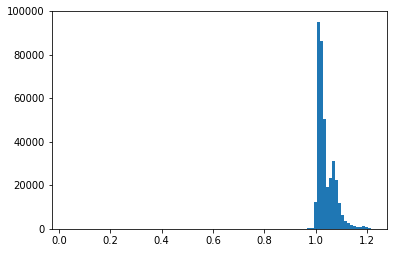

In [49]:
plt.hist(efficiency,bins=100)
plt.show()

In [50]:
outf = os.getenv('SCRATCH')+'/ELGMCeffHSCHP.fits'

In [51]:
import astropy.io.fits as fits
collist = []
collist.append(fits.Column(name='HPXPIXEL',format='K',array=pix['HPXPIXEL']))
collist.append(fits.Column(name='EFF',format='D',array=efficiency))
hdu  = fits.BinTableHDU.from_columns(fits.ColDefs(collist))
hdu.writeto(outf,overwrite=True)


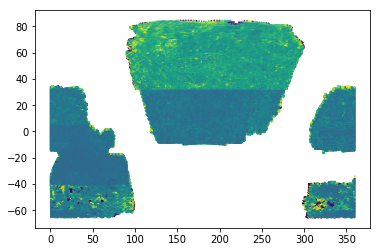

In [55]:
import healpy
th,phi = healpy.pix2ang(HPXNSIDE,pix['HPXPIXEL'],nest=True)
def thphi2radec(theta,phi):
    return 180./np.pi*phi,-(180./np.pi*theta-90)
ra,dec = thphi2radec(th,phi)
plt.scatter(ra,dec,c=efficiency,s=.1,vmin=.9,vmax=1.2)
plt.show()

In [59]:
old = fitsio.read(os.getenv('SCRATCH')+'/ELGMCeffHP.fits')

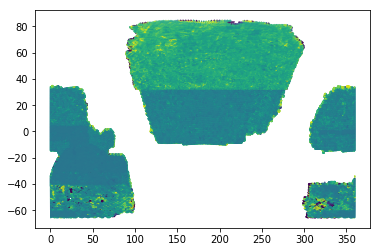

In [60]:
th,phi = healpy.pix2ang(HPXNSIDE,old['HPXPIXEL'],nest=True)
ra,dec = thphi2radec(th,phi)
plt.scatter(ra,dec,c=old['EFF'],s=.1,vmin=.9,vmax=1.2)
plt.show()

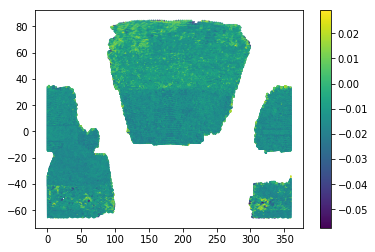

In [65]:
plt.scatter(ra,dec,c=efficiency-old['EFF'],s=.1)
plt.colorbar()
plt.show()

In [61]:
print(np.mean(efficiency-old['EFF']))

-0.0120154769646


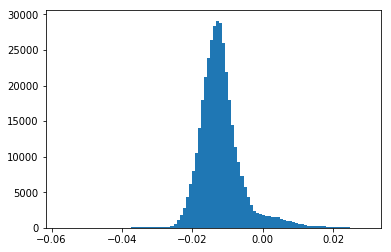

In [66]:
plt.hist(efficiency-old['EFF'],bins=100)
plt.show()


In [87]:
gsigd = gsigma*10**(0.4*R_G*pix["EBV"])
rsigd = rsigma*10**(0.4*R_R*pix["EBV"])
zsigd = zsigma*10**(0.4*R_Z*pix["EBV"])


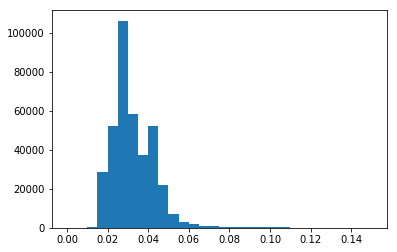

In [93]:
plt.hist(gsigd,bins=30,range=(0,.15))
plt.show()

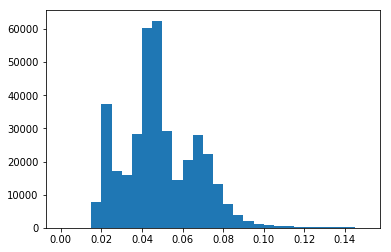

In [94]:
plt.hist(rsigd,bins=30,range=(0,0.15))
plt.show()

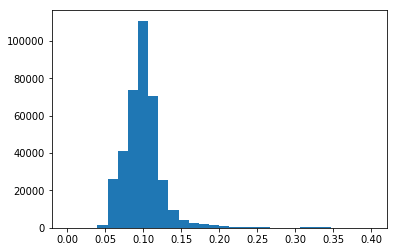

In [95]:
plt.hist(zsigd,bins=30,range=(0,0.4))
plt.show()

In [96]:
#now check histograms for actual data
elgf = os.getenv('SCRATCH')+'/ELGtargetinfo.fits'
felg = fitsio.read(elgf)

In [97]:
gsigmad=1./np.sqrt(felg[depth_keyword+"_G"])
rsigmad=1./np.sqrt(felg[depth_keyword+"_R"])
zsigmad=1./np.sqrt(felg[depth_keyword+"_Z"])


/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


In [98]:
gsige = gsigmad*10**(0.4*R_G*felg["EBV"])
rsige = rsigmad*10**(0.4*R_R*felg["EBV"])
zsige = zsigmad*10**(0.4*R_Z*felg["EBV"])


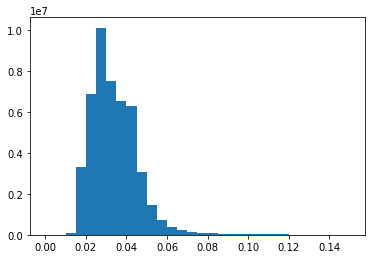

In [99]:
plt.hist(gsige,bins=30,range=(0,.15))
plt.show()

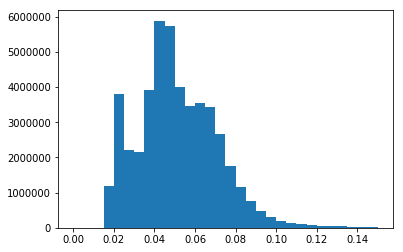

In [100]:
plt.hist(rsige,bins=30,range=(0,.15))
plt.show()

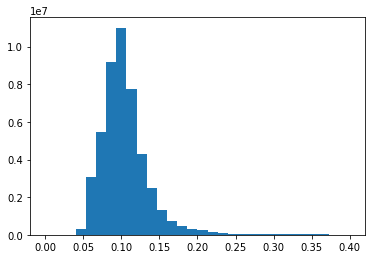

In [101]:
plt.hist(zsige,bins=30,range=(0,.4))
plt.show()

50**3.

In [102]:
50**3.

125000.0

In [103]:
30**3.

27000.0

In [123]:
fout = os.getenv('SCRATCH')+'/ELGeffgridsouth.dat'
fo = open(fout,'w')
fo.write('#gsig rsig zsig target_elg_eff true_elg_eff star_eff\n')
md = 0
xdg = 0.15
xdr = 0.15
xdz = 0.4
ngp = 30 #number of grid points for each band
for i in range(0,ngp):    
    dg = (xdg-md)/float(ngp)*i+0.5*(xdg-md)/float(ngp)
    for j in range(0,ngp):
        dr = (xdr-md)/float(ngp)*j+0.5*(xdr-md)/float(ngp)
        for k in range(0,ngp):
            dz = (xdz-md)/float(ngp)*k+0.5*(xdz-md)/float(ngp)
            eff,efft,effs = ELGeffcalc(dg,dr,dz,south=True)
            fo.write(str(dg)+' '+str(dr)+' '+str(dz)+' '+str(eff)+' '+str(efft)+' '+str(effs)+'\n')
            #if i == 0:
    print(i,dg,dr,dz,eff)        
fo.close()            

/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/desitarget/master/py/desitarget/cuts.py:315: RuntimeWarning: invalid value encountered in greater
  elg &= r - z > 0.3                  # blue cut.
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/desitarget/master/py/desitarget/cuts.py:316: RuntimeWarning: invalid value encountered in less
  elg &= r - z < 1.6                  # red cut.
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/desitarget/master/py/desitarget/cuts.py:317: RuntimeWarning: invalid value encountered in less
  elg &= g - r < -1.2*(r - z) + 1.6   # OII flux cut.
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/desitarget/master/py/desitarget/cuts.py:323: RuntimeWarning: invalid value encountered in less
  elg &= g - r < 1.15*(r - z) - 0.15
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid val

0 0.0025 0.1475 0.39333333333333337 0.806400196175
1 0.0075 0.1475 0.39333333333333337 0.806890632663
2 0.0125 0.1475 0.39333333333333337 0.809220205983
3 0.017499999999999998 0.1475 0.39333333333333337 0.813143697891
4 0.0225 0.1475 0.39333333333333337 0.814737616479
5 0.0275 0.1475 0.39333333333333337 0.820255026974
6 0.0325 0.1475 0.39333333333333337 0.826017655714
7 0.037500000000000006 0.1475 0.39333333333333337 0.829695929377
8 0.0425 0.1475 0.39333333333333337 0.834232466896
9 0.0475 0.1475 0.39333333333333337 0.843795978421
10 0.052500000000000005 0.1475 0.39333333333333337 0.851029916626
11 0.0575 0.1475 0.39333333333333337 0.860225600785
12 0.0625 0.1475 0.39333333333333337 0.869666503188
13 0.0675 0.1475 0.39333333333333337 0.878862187347
14 0.07250000000000001 0.1475 0.39333333333333337 0.886096125552
15 0.0775 0.1475 0.39333333333333337 0.888057871506
16 0.0825 0.1475 0.39333333333333337 0.878984796469
17 0.08750000000000001 0.1475 0.39333333333333337 0.862432564983
18 0.0

In [108]:
d = np.loadtxt(fout).transpose()

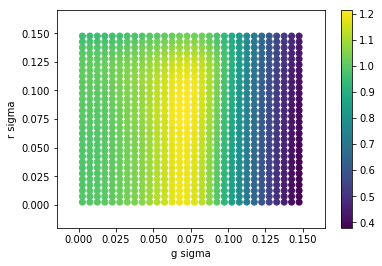

In [120]:
w = d[2] == 0.1
plt.scatter(d[0][w],d[1][w],c=d[3][w])
plt.xlabel('g sigma')
plt.ylabel('r sigma')
plt.colorbar()
plt.show()

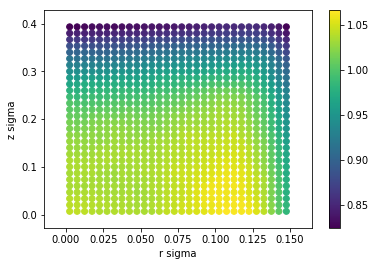

In [119]:
w = d[0] == 0.0325
plt.scatter(d[1][w],d[2][w],c=d[3][w])
plt.xlabel('r sigma')
plt.ylabel('z sigma')
plt.colorbar()
plt.show()

In [118]:
print(np.unique(d[2]))

[ 0.00666667  0.02        0.03333333  0.04666667  0.06        0.07333333
  0.08666667  0.1         0.11333333  0.12666667  0.14        0.15333333
  0.16666667  0.18        0.19333333  0.20666667  0.22        0.23333333
  0.24666667  0.26        0.27333333  0.28666667  0.3         0.31333333
  0.32666667  0.34        0.35333333  0.36666667  0.38        0.39333333]


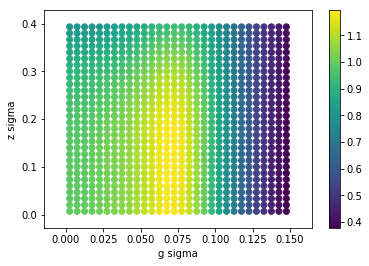

In [121]:
w = d[1] == 0.0325
plt.scatter(d[0][w],d[2][w],c=d[3][w])
plt.xlabel('g sigma')
plt.ylabel('z sigma')
plt.colorbar()
plt.show()